In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd.variable import Variable
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import imageio
import numpy as np
import matplotlib.pyplot as plt

torch.Size([1, 28, 28])


C:\Users\thaku\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


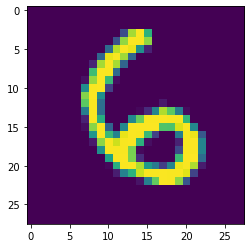

In [2]:
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,),(0.5,))
])

batch_size = 100 
trainset = MNIST(root='./data/', train=True, download=True, transform=transform) 

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

#added datavisualization flair to make sense of what I was actually doing.

dataiter = iter(trainloader)
images = dataiter.next()

x = images[0]

print(x[0].size())

plt.imshow(x[0].view(-1,28)) # gray scale images are suppoused to be(rows, columns)

In [3]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.n_features = 128 
        self.n_out = 784

        self.fc0 = nn.Sequential(
                    nn.Linear(self.n_features, 256),
                    nn.LeakyReLU(0.2)
                    )
        self.fc1 = nn.Sequential(
                    nn.Linear(256, 512),
                    nn.LeakyReLU(0.2)
                    )
        self.fc2 = nn.Sequential(
                    nn.Linear(512, 1024),
                    nn.LeakyReLU(0.2)
                    )
        self.fc3 = nn.Sequential(
                    nn.Linear(1024, self.n_out),
                    nn.Tanh() 
                    )
        
    def forward(self, x):
        x = self.fc0(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = x.view(-1, 1, 28, 28)
        return x

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.n_in = 784 
        self.n_out = 1 

        self.fc0 = nn.Sequential(
                    nn.Linear(self.n_in, 1024),
                    nn.LeakyReLU(0.2),
                    nn.Dropout(0.3)
                    )
        self.fc1 = nn.Sequential(
                    nn.Linear(1024, 512),
                    nn.LeakyReLU(0.2),
                    nn.Dropout(0.3)
                    )
        self.fc2 = nn.Sequential(
                    nn.Linear(512, 256),
                    nn.LeakyReLU(0.2),
                    nn.Dropout(0.3)
                    )
        self.fc3 = nn.Sequential(
                    nn.Linear(256, self.n_out),
                    nn.Sigmoid() 
                    )
        
    def forward(self, x):
        x = x.view(-1, 784) 
        x = self.fc0(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [5]:
generator = Generator()
discriminator = Discriminator()

g_optim = optim.Adam(generator.parameters(), lr=2e-4)
d_optim = optim.Adam(discriminator.parameters(), lr=2e-4)

criterion = nn.BCELoss()

g_losses = []
d_losses = []
images = []

def noise(n, n_features=128): 
    return Variable(torch.randn(n, n_features))

def make_ones(size):
    data = Variable(torch.ones(size, 1))
    return data

def make_zeroes(size):
    data = Variable(torch.zeros(size, 1))
    return data 

In [6]:
#Had to add .item() to the loss which is unlike that shown in general Vanilla GAN code, if .item() is not added, loss array is filled with tensor arrays that also have grad functions

def train_d(optimizer, real_data, fake_data):

    n = real_data.size(0)

    optimizer.zero_grad()

    real_pred = discriminator(real_data)
    real_error = criterion(real_pred, make_ones(n))
    real_error.backward()

    fake_pred = discriminator(fake_data)
    fake_error = criterion(fake_pred, make_zeroes(n))

    fake_error.backward()
    optimizer.step()

    return (real_error.item() + fake_error.item()) 

def train_g(optimizer, fake_data):
    n = fake_data.size(0)
    optimizer.zero_grad() 

    prediction = discriminator(fake_data)
    error = criterion(prediction, make_ones(n))

    error.backward()
    optimizer.step()

    return error.item()

    

In [7]:
epochs = 250
k = 1 
test_noise = noise(64)
generator.train()
discriminator.train()

for epoch in range(epochs):
    gerror = 0 
    derror = 0 

    for i, data in enumerate(trainloader):
        imgs, _ = data 
        n = len(imgs) #just batch size

        for j in range(k):
            fake_data = generator(noise(n)).detach()
            real_data = imgs 
            derror += train_d(d_optim, real_data=real_data, fake_data=fake_data)
        fake_data = generator(noise(n))
        gerror += train_g(g_optim, fake_data)

    img = generator(test_noise).cpu().detach()
    images.append(img)
    g_losses.append(gerror/i)
    d_losses.append(derror/i)
    print('Epoch {}: g_loss: {:.8f} d_loss: {:.8f}\r'.format(epoch, gerror/i, derror/i))
    
print('Training Finished')


Epoch 0: g_loss: 3.36067786 d_loss: 0.89723054
Epoch 1: g_loss: 1.63631733 d_loss: 1.08977938
Epoch 2: g_loss: 2.65087443 d_loss: 0.57900394
Epoch 3: g_loss: 3.87436812 d_loss: 0.33059466
Epoch 4: g_loss: 3.49570220 d_loss: 0.47869105
Epoch 5: g_loss: 3.16345634 d_loss: 0.50236134
Epoch 6: g_loss: 2.93272994 d_loss: 0.52596267
Epoch 7: g_loss: 2.67828158 d_loss: 0.58679542
Epoch 8: g_loss: 2.61139638 d_loss: 0.59114204
Epoch 9: g_loss: 2.33781330 d_loss: 0.68000346
Epoch 10: g_loss: 2.16249192 d_loss: 0.72018328
Epoch 11: g_loss: 1.93111045 d_loss: 0.79477422
Epoch 12: g_loss: 1.92363986 d_loss: 0.80551211
Epoch 13: g_loss: 1.88262150 d_loss: 0.82283956
Epoch 14: g_loss: 1.81967473 d_loss: 0.85402299
Epoch 15: g_loss: 1.79800611 d_loss: 0.84132616
Epoch 16: g_loss: 1.88224031 d_loss: 0.84417317
Epoch 17: g_loss: 1.72201913 d_loss: 0.88995501
Epoch 18: g_loss: 1.74196210 d_loss: 0.88821583
Epoch 19: g_loss: 1.71390847 d_loss: 0.87660262
Epoch 20: g_loss: 1.78600025 d_loss: 0.85425698
Ep

Text(0.5, 1.0, 'Trained GAN (250 Epochs)')

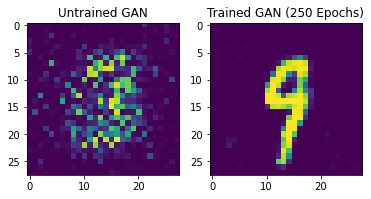

In [62]:
x = images[249]
x_1 = images[0]
yi = x_1[16].view(-1, 28)
yf = x[16].view(-1,28)

f, axarr = plt.subplots(1,2)
axarr[0].imshow(yi)
axarr[0].set_title('Untrained GAN')
axarr[1].imshow(yf)
axarr[1].set_title('Trained GAN (250 Epochs)')

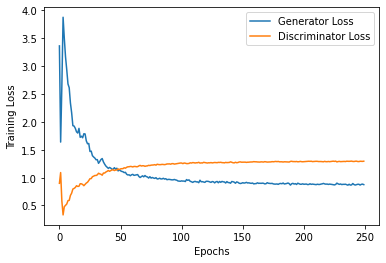

In [50]:
x_val = []
for i in range(0,epochs+1):
    x_val.append(i)


plt.plot(x_val,g_losses, label='Generator Loss')
plt.plot(x_val,d_losses, label='Discriminator Loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Training Loss")

plt.show()